In [46]:
from src.data_utils import load_xsum_dict, load_shuffled_test_split

xsum_test = load_xsum_dict("test")
bart_test_extrinsic = load_shuffled_test_split(xsum_test, "bart-test-extrinsic", len(xsum_test))
print(
    len(bart_test_extrinsic),
    len(bart_test_extrinsic) / len(xsum_test)
)
pegasus_test_extrinsic = load_shuffled_test_split(xsum_test, "pegasus-test-extrinsic", len(xsum_test))
print(
    len(pegasus_test_extrinsic),
    len(pegasus_test_extrinsic) / len(xsum_test)
)

Using custom data configuration default
Reusing dataset xsum (/Users/anton164/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

6823 0.6019940003529204
6988 0.6165519675313217


In [61]:
import pandas as pd
import json
import numpy as np


def read_logs(path):
    with open(
        path,
        "r"
    ) as f:
        iteration_logs = json.load(f)

    data = []
    edits_by_sum_id = {}
    total_gens = 0
    for iteration in iteration_logs:
        total_gens += iteration["summary_generated"]
        for sum_id, sum_data in iteration["summary"].items():
            if "edit_stats" in sum_data and sum_id in xsum_test:
                if sum_id not in edits_by_sum_id:
                    edits_by_sum_id[sum_id] = {}
                edits_by_sum_id[sum_id]["token"] = sum_data["edit_stats"]["edit_distance_token"]
                # edits_by_sum_id[sum_id]["rouge1"] = sum_data["edit_stats"]["rouge1"]
                # edits_by_sum_id[sum_id]["rouge2"] = sum_data["edit_stats"]["rouge2"]
                # edits_by_sum_id[sum_id]["rougeL"] = sum_data["edit_stats"]["rougeL"]

        if iteration["iteration"] == 0 and "full" in path:
            for sum_id in xsum_test.keys():
                if sum_id not in edits_by_sum_id:
                    edits_by_sum_id[sum_id] = {}
                    edits_by_sum_id[sum_id]["token"] = 0

        result_obj = {
            "iteration": iteration["iteration"],
            "summary_factual": iteration["factuality_summary"]["factual"],
            "summary_non_factual": iteration["factuality_summary"]["non_factual"],
            "summary_unknown": iteration["factuality_summary"]["unknown"],
            "summary_failed": iteration["factuality_summary"]["failed"],
            "mean_edit_distance_token": np.mean(
                [x["token"] for x in edits_by_sum_id.values()]
            ),
            # "mean_edit_distance_rouge1": np.mean(
            #     [x["rouge1"] for x in edits_by_sum_id.values()]
            # ),
            # "mean_edit_distance_rouge2": np.mean(
            #     [x["rouge2"] for x in edits_by_sum_id.values()]
            # ),
            # "mean_edit_distance_rougeL": np.mean(
            #     [x["rougeL"] for x in edits_by_sum_id.values()]
            # )
        }
        data.append(result_obj)
    print("total gens", total_gens)
    return pd.DataFrame(data).set_index("iteration"), iteration_logs, edits_by_sum_id

dataset = "bart-full"
df_clf, logs_clf, edits_clf = read_logs(
    f"results/iteration-changes/{dataset}-classifier-knnv1.json"
)

df_clf

total gens 20901


,summary_factual,summary_non_factual,summary_unknown,summary_failed,mean_edit_distance_token
iteration,,,,,
0,0.074996,0.015264,0.909741,0,0.000000
1,0.079495,0.015970,0.904535,53,1.946974
2,0.081260,0.031233,0.887507,244,2.192871
3,0.082936,0.045350,0.871713,413,2.315246
4,0.083113,0.086201,0.830686,889,2.331833
5,0.083201,0.096083,0.820716,1008,2.338804
6,0.083377,0.101112,0.815511,1066,2.335627
7,0.083377,0.102965,0.813658,1087,2.333774
8,0.083377,0.103759,0.812864,1095,2.334127


In [48]:
edit_distances = []
for x in edits_clf.values():
    if x["token"] != 0:
        edit_distances.append(x["token"])
edit_distance_weights = np.ones_like(edit_distances)/float(len(edit_distances))
edit_distance_weights


print(len(edit_distances))

3568


In [49]:
np.unique(edit_distances, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36]),
 array([502, 340, 331, 275, 237, 236, 224, 192, 152, 120, 145, 127, 102,
         83,  92,  62,  63,  64,  62,  52,  31,  25,  12,  18,   5,   5,
          2,   2,   2,   1,   1,   1,   1,   1]))

In [50]:
sum(
    np.unique(edit_distances, return_counts=True)[1][:6] / sum(np.unique(edit_distances, return_counts=True)[1])
)

0.538396860986547

In [51]:
(np.unique(edit_distances, return_counts=True)[1] / len(edit_distances))[0]

0.14069506726457398

In [52]:
from plot_styling import set_plot_styling
set_plot_styling()

3568 0.3148050114699135


<AxesSubplot:xlabel='Word Edit Distance', ylabel='Fraction of\nXSum Test'>

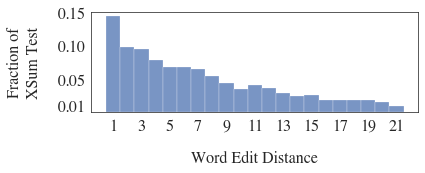

In [53]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

plt.figure(figsize = (6, 2.5))
ax = sns.histplot(
    edit_distances,
    bins=np.arange(1, 23) - 0.5,
    #bins=np.array([0, 1, 2, 3, 4, 5, 6, 11, 16, 21, 22]) - 0.5,
    stat="density",
    # discrete=True,
    # kde=True,
    # kde_kws={'clip': (1.5, 40)}
)
# plt.hlines(0.152, -0.5, 0.5, color='lightgray', linewidth=33.5)
#rect = ax.patches.Rectangle((10, 10), , linewidth=1, edgecolor='r', facecolor='none')
#ax.add_patch(rect)
ax.set_xticks(range(1, 22, 2))
ax.set_xlabel("Word Edit Distance", fontsize=16, labelpad=16)
ax.set_ylabel("Fraction of\nXSum Test", fontsize=16, labelpad=16)
#ax.set_yscale('log')
ax.yaxis.set_ticks([0.01, 0.05, 0.1, 0.15])
# ax.set_ylim(0, 0.2)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))


plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/word_distance.pdf")
print(len(edit_distances), len(edit_distances) / len(xsum_test))
ax

In [54]:
np.arange(0, 23)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

Text(0.5, 0, 'Word edit distance')

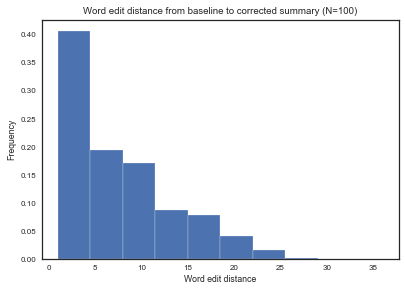

In [55]:
import matplotlib as mpl
mpl.style.use(["seaborn-white", "seaborn-paper"])
#define style
#sns.set_theme()
fig, ax = plt.subplots()
ax.hist(
    edit_distances, 
    weights=edit_distance_weights
)
ax.set_title("Word edit distance from baseline to corrected summary (N=100)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Word edit distance")

NameError: name 'df_oracle' is not defined

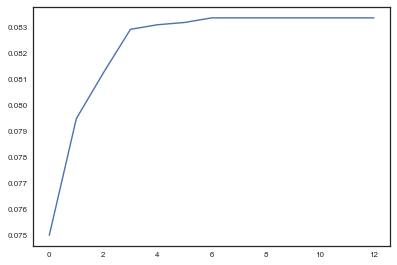

In [57]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

# Be sure to only pick integer tick locations.
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(
    df_clf.index,
    df_clf.summary_factual,
    label="BART + GEF"
)
ax.plot(
    df_oracle.index,
    df_oracle.summary_factual,
    label="BART + GEF Oracle"
)
ax.margins(0.05)
ax.axis('tight')
fig.tight_layout()
plt.ylabel("Factual Summaries")
plt.xlabel("Max number of Iterations")
plt.legend()
# TODO change to histogram to show how many iterations it takes on average
# Seaborn paper mode